# **Section 1: Problem Description**

## 1. Problem Statement
* Clearly define the image classification task
* Describe the motivation for GPU acceleration

#### Clearly define the image classification task
- The core objective of this project is to build an Autoemcoder-based unsupervised feature learning system for image classification on the CIFAR-10 dataset.This process is implemented in a two-stage pipeline:
- Stage 1 - Unsupervised Feature Learning:
  - Train a Convolutional Autoencoder to reconstruct $32 \times 32 \times 3$ input images from CIFAR-10.
  - The Autoencoder learns to compress the image into an 8,192-dimensional feature representation.
  - The network is trained to minimize the reconstruction error (MSE Loss), forcing the encoder to capture essential visual patterns (edges, textures, shapes) without using any class labels
- Stage 2 - Supervised Classification:
  - Use the trained encoder to extract features for all images. Then, a Support Vector Machine (SVM) classifier is trained on these learned features using the class labels.
  - The final performance is evaluated on the test set.
- Dataset and Performance TargetDataset: CIFAR-10 (60,000 total images, $32 \times 32$ pixels, 10 classes).
- Target Accuracy: The project aims for a Test classification accuracy of 60-65%.

#### Describe the motivation for GPU acceleration
- The primary motivation for implementing the project's core components (Autoencoder training and feature extraction) in CUDA is to overcome CPU performance limitations and meet aggressive time targets.
- Training the Convolutional Autoencoder is a computationally intensive task that can take hours on a CPU. The goal is to reduce the Autoencoder training time to less than 10 minutes on the GPU.
- Through systematic optimization, the project aims to accelerate the autoencoder dramatically, targeting a GPU speedup over CPU of >20x.
- The process of running the encoder to extract features for all 60,000 images must also be highly optimized, with a target Feature extraction time of less than 20 seconds.
- The project's main focus is on implementing and optimizing the autoencoder training and inference in CUDA, while utilizing existing optimized libraries (like LIBSVM) for the subsequent SVM classification step.

## 2. CIFAR-10 Dataset Overview
* Dataset specifications (size, classes, split)
* Show sample images from each class (use visualization)
* Explain data preprocessing steps (normalization, format)

#### **Dataset Specifications**

The dataset is prized for its manageable size, allowing researchers to quickly iterate on different neural network architectures.

| Feature | Specification |
| --- | --- |
| **Total Images** | 60,000 |
| **Image Resolution** | 32 x 32 pixels |
| **Color Channels** | 3 (RGB) |
| **Format** | Color (uint8) |
| **File Size** | ~162 MB (binary version) |

#### **Classes**

The dataset contains 10 distinct classes, with exactly 6,000 images per class. The classes are completely mutually exclusive .

1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck

#### **Data Split**

The 60,000 images are split into two main subsets to ensure standardized benchmarking:

* **Training Set (50,000 images):** Divided into 5 training batches, each containing 10,000 images. While the total training set is balanced (5,000 images per class), individual batches may have a slightly different distribution.
* **Test Set (10,000 images):** Contains exactly 1,000 randomly selected images from each class.

#### **Sample Image**

In [1]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
!tar -xzf cifar-10-binary.tar.gz
!ls cifar-10-batches-bin/

--2025-12-19 06:59:55--  https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170052171 (162M) [application/x-gzip]
Saving to: ‘cifar-10-binary.tar.gz’

cifar-10-binary.tar 100%[===================>] 162.17M  25.9MB/s    in 6.8s    

2025-12-19 07:00:02 (23.8 MB/s) - ‘cifar-10-binary.tar.gz’ saved [170052171/170052171]

batches.meta.txt  data_batch_2.bin  data_batch_4.bin  readme.html
data_batch_1.bin  data_batch_3.bin  data_batch_5.bin  test_batch.bin


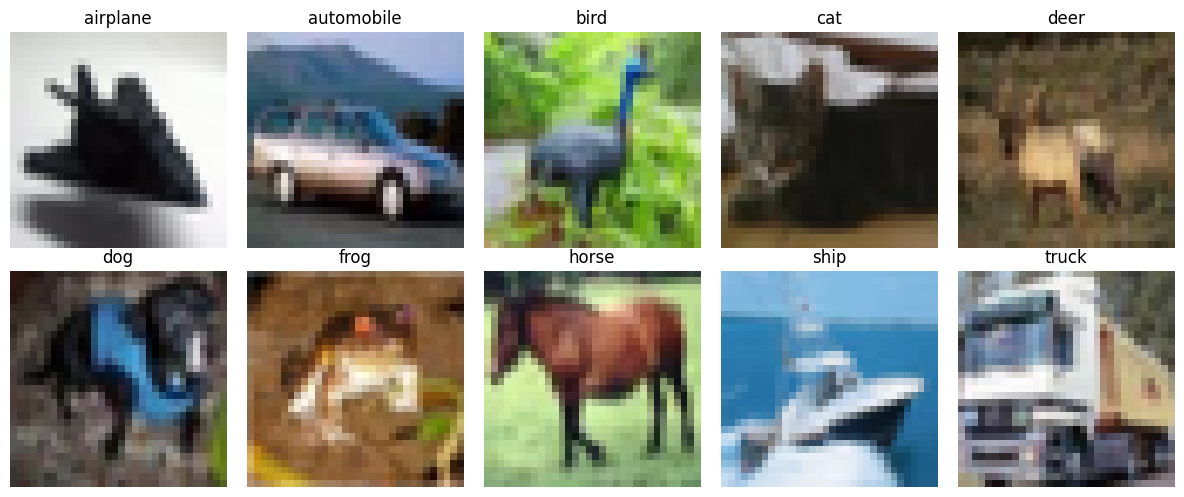

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def load_all_from_bin(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    data = data.reshape(-1, 3073)
    labels = data[:, 0]
    images = data[:, 1:].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

all_imgs, all_lbls = load_all_from_bin('./cifar-10-batches-bin/data_batch_1.bin')

unique_indices = [np.where(all_lbls == i)[0][0] for i in range(10)]

imgs = all_imgs[unique_indices]
lbls = all_lbls[unique_indices]

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.title(f"{class_names[lbls[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

#### **Data preprocessing steps**

There are three main stages

**1. Structural Parsing and Memory Management**

The process begins by reading the raw binary files into system memory to separate the labels from the pixel data.

* **Record Structure**: Each image in the CIFAR-10 binary format is stored as a 3073-byte record, where the first byte is the label and the remaining 3072 bytes are the image data.
* **Label Extraction**: The code iterates through the raw buffer, extracting the first byte of every record and storing it into an integer array (`labels`).
* **Image Buffer Isolation**: The pixel data (3072 bytes per image) is copied into a separate `raw_images` buffer, effectively stripping the labels to prepare for batch processing on the GPU.

**2. GPU-Accelerated Normalization**

The core of the preprocessing is the normalization step, which shifts pixel values from an integer range to a floating-point range for better gradient flow during training.

* **Data Type Conversion**: Converts the input `uint8` (0–255) pixel values into `float32`.
* **CUDA Kernel Execution**: A specific GPU function, `normalizeKernel`, is launched where each thread processes a single pixel to compute output[idx] = input[idx] / 255.0f.
* **Standardized Range**: This result ensures all input features are scaled to the range [0.0, 1.0], which is verified at the end of the loading process by calculating the minimum and maximum values in the final array.
* **CPU Fallback**: If a CUDA-enabled device is not detected, the code includes a nested loop fallback to perform the same division on the CPU.

**3. Dataset Organization and Shuffling**

Once the data is normalized, it is organized into a structured `Dataset` object for easier handling by the training loop.

* **Random Shuffling**: The `shuffle_dataset` function uses a Mersenne Twister random number generator (`mt19937`) to shuffle an index vector. It then rearranges the image and label memory based on these random indices to ensure the model does not learn the order of the classes.
* **Minibatch Creation**: The `create_minibatches` function partitions the full dataset into smaller, fixed-size `Dataset` objects (batches). This allows the training process to perform weight updates more frequently and manage memory more efficiently.

## 3. Autoencoder Architecture
* Describe the network architecture with a diagram
* Specify layer dimensions and transformations
* Explain the encoder-decoder structure and latent representation
* Include architecture visualization

#### **Encoder Structure**:
* **Goal**: The encoder progressively reduces the spatial dimensions (width and height) of the input data while extracting high-level features.
* **Spatial Compression**: It uses a sequence of convolutional and average pooling layers to shrink the input. Each pooling stage reduces the width and height by a factor of 2 (a total spatial reduction of 4x across the full encoder).


* **Latent Representation**:
* The compressed output of the encoder serves as the latent representation.
* This representation contains the most essential features of the input data in a lower-dimensional format.


#### **Decoder Structure**:
* **Goal**: The decoder mirrors the encoder to reconstruct the original input from the latent representation.
* **Spatial Expansion**: It utilizes upsampling layers to restore spatial dimensions. Each upsampling stage doubles the width and height, effectively undoing the compression performed by the pooling layers.


#### **Layer Dimensions and Transformations**

The CPU implementation defines several core transformations that modify data dimensions as it passes through the network.

| Layer Type | Forward Transformation Logic |
| --- | --- |
| **Conv2D** | Applies filters to extract features; maintains spatial dimensions via implicit zero-padding. |
| **ReLU** | Element-wise activation: $f(x) = \max(0, x)$. . | No change |
| **AvgPool** | A $2 \times 2$  window averages four pixels into one. |  
| **Upsample** | A single pixel is duplicated into a $2 \times 2$  output block (Nearest Neighbor). |  

#### **Architecture Visualization**

The overall architecture follows a symmetrical flow of compression and expansion:

1. **Input Layer**: Original image data ().
2. **Encoder Stages**:
* `cpu_conv2D`  `cpu_relu`
* `cpu_avg_pooling` (Reduces  by half)


3. **Latent Representation**: The final compressed feature map.
4. **Decoder Stages**:
* `cpu_upsampling` (Doubles )
* `cpu_conv2D`  `cpu_relu`


5. **Output Layer**: Reconstructed data aimed at matching the input.


## 4. Project Objectives
* Performance goals (training time, speedup targets, accuracy)
* Technical learning objectives
* Success criteria

#### **Performance Goals**

- These are the required numerical targets you must achieve through systematic optimization in CUDA. Achieving these goals is the primary measure of success for the project's performance aspect.

| Metric | Target |
| :--- | :--- |
| **Autoencoder training time** | **<10 minutes** |
| **Feature extraction time** | **<20 seconds** (for all 60,000 images)  |
| **Test classification accuracy** | **60-65%**  |
| **GPU speedup over CPU** | **>20x**  |


#### **Technical Learning Objectives**

- The project serves as an intensive exercise in **parallel programming** and deep learning implementation by requiring implementation from the ground up.

* Learn to design, implement, and debug efficient parallel kernels for deep learning primitives, including Convolution , ReLU , Max Pooling/ AVG Pooling  and UpSampling.
* Understand and apply advanced optimization techniques (e.g., Shared Memory Tiling, Kernel Fusion, Memory Coalescing, Multi-Stream Pipeline) to maximize GPU efficiency and memory bandwidth utilization.
* Gain a comprehensive understanding of the Autoencoder architecture (forward and backward passes) and implement the complete network from scratch.
* Successfully integrate the high-speed CUDA-accelerated feature extractor with a standard machine learning library (LIBSVM) to complete the two-stage feature learning and classification pipeline.

#### **Success Criteria**

Project success is evaluated by the functional completeness of the pipeline and the achievement of the specified targets.

1. All GPU layer implementations must be verified against the CPU baseline implementation to ensure mathematical accuracy.
2. All quantitative targets for training time, feature extraction time, and GPU speedup must be met or exceeded.
3.  The final classification accuracy on the test set must fall within the target range of **60-65%**, validating the quality of the learned features.
4.  Deliver a detailed, executable Jupyter Notebook report documenting the progressive optimization phases, profiling analysis, results, and key lessons learned.

# Section 2: Implementation Phases

### Objectives:
* What you aimed to achieve in this phase
* Why this phase is necessary

#### **What you aimed to achieve in this phase**
- The aim of Phase 2.1 is to build a complete, functional, and measurable CPU implementation of the entire data pipeline and neural network architecture.
- Data Pipeline Completion: Successfully implement the data loading process for CIFAR-10, including parsing the binary format, normalizing pixel values from [0,255] to [0,1], implementing batch generation, and adding data shuffling.
- CPU Layer Implementation: Create CPU versions of all necessary operations for the Autoencoder: Convolution (Conv2D), ReLU Activation, AVG Pooling, Upsampling (Nearest Neighbor interpolation), and MSE Loss.
- Full Autoencoder Functionality: Encapsulate the network architecture into an Autoencoder class, implement weight initialization, manage memory for intermediate activations, and develop the full Forward Pass and Backward Pass (including gradient calculation and weight update logic).
- Establish Baseline Performance: Run the full CPU training loop for a set number of epochs to measure and track the time per epoch and the total training time, thereby establishing the crucial baseline performance.

#### **Why This Phase is Necessary**
- The CPU baseline is not just an intermediary step; it is critical for validating the entire project moving forward.
- The CPU implementation serves as the indispensable "gold standard" reference. Before any optimization, the complex GPU kernels developed in Phase 2 must be verified against the CPU output to ensure they are mathematically accurate and producing the correct results for the forward and backward passes.
- The measured CPU training time is the benchmark against which all subsequent GPU optimization phases are measured. Without a verifiable CPU baseline, you cannot calculate the required >20× speedup target.
- It allows for debugging the high-level neural network logic (weight updates, backpropagation chain, hyperparameter settings) in a familiar CPU environment before dealing with the added complexity of parallel execution and GPU memory management (host/device transfers).

### Implementation Details:
* Data Pipeline: How you loaded and pre-processed CIFAR-10 data
* Layer Implementations: Brief description of each layer (Conv2D, ReLU,
MaxPool, Upsample)
* Training Loop: How you structured the training process
* Key Code Snippets: Show 2-3 critical functions (e.g., convolution function
signature and main loop structure)

#### **Data Pipeline:**
- The data is loaded from the standard CIFAR-10 binary format, where each record contains 1 byte for the label followed by 3072 bytes for the image (32 (width) x 32 (height) x 3 (depth)).
  - Training Data: Loaded from five separte batch files (data_batch_1.bin through data_batch_5.bin), totaling 50.000 samples.
  - Test Data: Loaded from a single test_batch.bin file, totaling 10.000 samples.
  - Dataset Structure: The loaded and pre-processed data is stored in a Dataset object, which manages the image data and labels using `unique_ptr` for memory safety.
- The raw unsigned char pixel values, which range from [0,255], are normalized to float values in the range [0,1].
  - CPU Normlization (Fallback): If CUDA is unavailable, the normalization is performed on the CPU using a standard loop:
  $\text{output}[\text{idx}] = \text{input}[\text{idx}] / 255.0\text{f}$.
  - CUDA Normalization (Default): If a CUDA device is detected, the normalization is offloaded to the GPU for parallel processing.
    - Raw image data is copied to the device
    - A CUDA kernel is launched to perform the $\text{value} / 255.0\text{f}$ calculation in parallel across all pixels .
    - The resulting normalized float data is copied back to the host memory.
- Two ultilities are available to manage the data during the training process:
  - The `shuffle_dataset` function shuffles the order of images and their corresponding labels by shuffling a list of indices and then copying the data based on the index order.
  - The `create_minibatches` function splits the full Dataset into a vector of smalles Dataset objects for efficient stochastic training.

#### **Layer Implementations:**

**1. Conv2D (Convolutional Layer)**

This layer acts as a feature extractor by sliding learned filters across the input data.

* **Forward Pass (`cpu_conv2D`)**: It computes a weighted sum by sliding a filter of size `CONV_FILTER_WIDTH`  `CONV_FILTER_HEIGHT` over the input. It uses nested loops to iterate through images, filters, depth channels, and spatial coordinates.
* **Padding**: The implementation handles boundaries by skipping calculations if the filter window extends outside the input dimensions, effectively performing zero-padding.
* **Backward Pass (`cpu_conv2D_grad`)**: It calculates the gradient for the filters by correlating the input with the output error (`d_out`), determining how much each filter weight contributed to the loss.

**2. ReLU (Rectified Linear Unit)**

ReLU is a non-linear activation function that helps the network learn complex patterns.

* **Forward Pass (`cpu_relu`)**: It performs an element-wise operation where any negative input value is set to zero, while positive values remain unchanged ().
* **Backward Pass (`cpu_relu_backward`)**: It passes the gradient through only if the original input was positive. If the input was , the gradient is set to zero, effectively "deactivating" that neuron during the update.

**3. AvgPool (Average Pooling)**

Pooling layers reduce the spatial resolution of the data to make the model more efficient and robust.

* **Forward Pass (`cpu_avg_pooling`)**: It reduces the width and height of the input by half. For every  block of pixels, it calculates the average value and writes it to the output.
* **Backward Pass (`cpu_avg_pooling_backward`)**: It distributes the gradient from the output back to the input. Each of the four original pixels in the  block receives exactly  of the incoming gradient.

**4. Upsampling**

Upsampling increases the spatial dimensions, often used in generative tasks or autoencoders.

* **Forward Pass (`cpu_upsampling`)**: It doubles the width and height of the input. It uses a "Nearest Neighbor" approach, where a single input pixel value is copied into a  block in the output.
* **Backward Pass (`cpu_upsampling_backward`)**: This is the inverse of the forward pass. It sums the gradients of the  output block and assigns the total sum back to the single corresponding input pixel.

#### **Training Loop**:
- The training process is structured within the `Cpu_Autoencoder::fit`method, which manages the overall training flow, including batch iteration, loss calculation, backpropagation, and parameter updates for the entire network.
- The `fit` method handles the high-level organization of training:
  - Batching: The input Dataset is first split into a vector of smaller minibatches.
  - Memory Allocation: Temporary memory for intermediate layer outputs and gradient arrays(`_d_in`,`_d_out`, `_d_filter`) is allocated on the CPU based on the `batch_size`.
  - Epoch Loop: An outer loop iterates through the specified number of training `n_epoch`.
  - Batch Loop: An inner loop processes every minibatch, calling the core `_fit_batch` function.
  - Reporting and Saving: After each epoch, the average loss is calculated and printed, and if checkpoints are configured, the model parameters are saved.
- The `_fit_batch` function is the heart of the training process, executing a complete optimization step for a single minibatch:
1. **Forward Pass**: The data is passed through the entire Autoencoder (Encoder then Decoder). The output of every intermediate layer is calculated and saved into the corresponding _out_... arrays. This is done by chaining the `_encode_save_output` and `_decode_save_output` methods.
2. **Loss Calculation**: The reconstruction loss is calculated using the Mean Squared Error (MSE) between the original input (expected) and the final reconstructed output (actual).

$$\text{loss} = \text{cpu_mse_loss}(\text{expected}, \text{actual}, \dots) \text{}$$

3. **Initial Gradient**: The gradient of the loss function is calculated (d_out) to kick off the backpropagation.

- The gradient is passed backward through the layers from the Decoder's final layer to the Encoder's first layer, performing three actions at each step:
  - **Parameter Gradient**: Calculate the gradient of the loss with respect to the layer's parameters (filters and biases) using `cpu_conv2D_grad` and `cpu_bias_grad`.
  - **Parameter Update**: Update the layer's weights and biases using `cpu_update_weight` and the `learning_rate`.
  $$\mathbf{W}_{\text{new}} = \mathbf{W}_{\text{old}} - \text{learning_rate} \cdot \nabla J(\mathbf{W}) \text{}$$
  - **Delta Propagation**: Calculate the delta (gradient) for the preceding layer (d_in) using the backward functions. The `swap(d_out, d_in)` operation is used after propagation to efficiently alternate the roles of the two temporary gradient arrays for the next backward step.

#### **Key Code Snippets**
1. **Conv2D Forward Pass Implementation**
- The `cpu_conv2D` function implements the forward pass of the Convolutional layer, which is fundamental to both the Encoder and Decoder.
  - Funtction Role: Performs a 2D convolution with a 3 x 3 kernel, a stride of 1 and simulated padding of 1. This ensures the output feature map dimensions remain the same as the input dimensions (W x H).
  - It iterates through every pixel location (i,j) in the output image and every filter (f). For each filter, it calculates the dot product between the kernel window and the input data across all input depth channels (d). The sum of this dot product becomes the value for the corresponding output pixel in channel f.
2. **Weight Update Mechanism**
- The `cpu_update_weight` function performs the final step of the learning process - modifying the parameters (weights or biases) based on the calculated gradient.
  - Function Role: Implements the core Gradient Descent step.
  - It updates every element in the parameter array (weight) by subtracting the scale gradient (grad):
  $$\mathbf{W}_{\text{new}}[i] = \mathbf{W}_{\text{old}}[i] - \text{learning_rate} \cdot \mathbf{\text{grad}}[i] \text{}$$

### Results:
* Training time per epoch and total training time
* Final reconstruction loss
* Sample reconstructed images (show original vs reconstructed)
* Memory usage

In [ ]:
!g++ main.cpp data_loader.cpp cpu_autoencoder.cpp cpu_layers.cpp timer.cpp progress_bar.cpp utils.cpp -std=c++17 -O2 -o cpu_main11.exe

In [ ]:
!cpu_main11.exe

In [ ]:
!cpu_main

========== LOAD DATASET ==========
Loading training data from ./cifar-10-batches-bin...
  âœ“ Loaded batch 1/1
âœ“ Training data loaded: 10000 samples
  Data range: [0.0000, 1.0000]
Train samples: 10000

========== INIT AUTOENCODER ==========

========== START TRAIN ==========
=======================TRAINING START=======================
Epoch 1:

Batch 000/313 [>                                                 ] (00%)
Batch 001/313 [>                                                 ] (00%) - Loss = 1.9498 - Time = 5.805s
Batch 002/313 [>                                                 ] (01%) - Loss = 1.8219 - Time = 17.802s
Batch 003/313 [>                                                 ] (01%) - Loss = 1.6031 - Time = 32.424s
Batch 004/313 [>                                                 ] (01%) - Loss = 1.4347 - Time = 46.585s
Batch 005/313 [>                                                 ] (02%) - Loss = 1.3103 - Time = 1m 0s
Batch 006/313 [>                                   

### Key Takeaways:
* What did you learn about the algorithm?
* What insights guided your GPU implementation?

#### **What did you learn about the algorithm?**
- The algorithm follows a mirrored structure where the Encoder reduces spatial dimensions (Width/Height) by 4x through two pooling stages, while the Decoder restores them using two upsampling stages.
- By reducing the  dimensions while modifying the depth (channels), the algorithm forces the network to learn only the most essential features in the "bottleneck" layer.
- The algorithm relies on the Chain Rule of calculus. Error gradients are calculated at the output and propagated backward. Each layer calculates its own weight updates before passing the "delta" (error) to the previous layer.
#### **What insights guided your GPU implementation?**
On the CPU, convolution requires a deeply nested 6-level loop (Batch  Depth  Height  Width  Filter Window) that processes one pixel at a time.

- The GPU implementation flattens these spatial loops by mapping each output pixel and filter to a unique thread in a 3D grid.
- This allows the hardware to calculate thousands of pixels simultaneously rather than iterating through them one by one.

In the backward pass (gradient calculation), a "many-to-one" update problem occurs because many different input pixels contribute to the gradient of a single filter weight.

- While the CPU version simply uses a standard `+=` operator because it is single-threaded, the GPU version must use `atomicAdd`.
- This ensures that when multiple parallel threads attempt to update the same filter weight simultaneously, the updates are synchronized and no data is lost to race conditions.

Calculating the Mean Squared Error (MSE) loss requires summing values across the entire dataset to get a single average.

- Performing thousands of global `atomicAdd` operations would create massive memory bandwidth congestion. Instead, the implementation utilizes **Shared Memory** to perform block-level reductions.
- By performing most of the summation inside the fast, on-chip shared memory and only writing to global memory once per block, the implementation drastically reduces bandwidth overhead.



## Phase 2.2: GPU Basic Implementation

### Objectives:
* Port CPU code to GPU with basic parallelization
* Verify correctness of GPU kernels
* Establish baseline GPU performance

### Implementation Details:
* Parallelization Strategy: How you mapped operations to GPU threads
* Kernel Designs:
  * Convolution kernel: thread-to-output mapping
  * Pooling kernel: how threads handle 2×2 windows
  * Other kernels (ReLU, upsampling)
* Memory Management: Device memory allocation strategy
* Key Code Snippets: Show kernel signatures and launch configurations

#### **Parallelization Strategy**

**1. Spatial and Channel Mapping**

While the CPU version uses nested `for` loops to iterate through height, width, and filters, the GPU version maps these dimensions directly to the CUDA grid:

* **X and Y Dimensions:** These are mapped to the image **Width** and **Height**. Each thread handles the computation for a specific pixel coordinate $(x, y)$ in the output feature map.
* **Z Dimension:** This is mapped to the **Filters** (output depth) or **Input Depth**. This allows the GPU to compute all feature maps for a given spatial location in parallel.
* **Linear Indexing:** To access the flattened memory buffers, a macro `GET_1D_IDX` is used to translate 3D logic coordinates into a 1D memory address.

**2. Thread-to-Output Mapping**

The core strategy for operations like Convolution, Pooling, and Upsampling is a **thread-to-output** assignment:

* **Convolution:** Each thread $(x, y, f)$ calculates the weighted sum for exactly one pixel in one output filter. It loops through the small $3 \times 3$ filter window internally, but the heavy lifting of processing thousands of pixels and hundreds of filters happens across the grid.
* **Pooling:** Each thread is assigned to one pixel in the reduced-size output. It fetches the $2 \times 2$ neighborhood from the input, calculates the average, and writes the result.
* **Upsampling:** A single thread reads a value from the input and "broadcasts" it to four corresponding locations in the expanded output buffer.

**3. Batch Processing Logic**
* **Host-Side Loop:** The CPU (Host) iterates through the batch size n.
* **Kernel Invocation:** For each image in the batch, the GPU kernel is launched with a calculated memory offset. This ensures high parallelism within each image while keeping the memory management and indexing logic predictable for the developer.

**4. Gradient Accumulation and Reduction**

During backpropagation, the mapping strategy adapts to handle many-to-one updates:

* **Atomic Additions:** In the Convolution Gradient kernel, many threads (representing different image pixels) contribute to the update of a single filter weight. The code uses `atomicAdd` to ensure these updates are synchronized and no data is lost to race conditions.
* **Shared Memory Reduction:** For calculating the Mean Squared Error (MSE), the strategy uses `__shared__` memory within blocks. Threads first sum their local values in high-speed shared memory before a single thread updates the global total, significantly reducing the pressure on the global memory bus.

#### **Kernel Designs**

**Convolution Kernel: Thread-to-Output Mapping**

The `gpu_conv2D_kernel` is designed to maximize spatial parallelism by assigning each output pixel to a unique GPU thread.

* **Thread Assignment**: Each thread identifies its position in the output feature map using its 3D coordinates $(x, y, f)$, where x and y are spatial dimensions and f is the filter index.
* **Internal Computation**: Every thread performs a nested loop over the filter's width and height, and across all input depths, to calculate the weighted sum for its specific pixel.
* **Boundary Handling**: The kernel includes conditional logic to check if a neighbor is within image bounds; if not, it skips the calculation, effectively implementing implicit zero-padding.
* **Launch Logic**: The kernel is launched inside a host-side loop that iterates through the batch, calculating the necessary memory offsets for each image.

**Pooling Kernel: 2x2 Window Handling**

The `gpu_avg_pooling_kernel` handles spatial downsampling by mapping threads to the reduced output dimensions.

* **Window Processing**: Each thread is assigned to one pixel in the output feature map, which corresponds to a $2 \times 2$ window in the input feature map.
* **Average Calculation**: The thread fetches the four neighboring pixels $(in\_y, in\_x), (in\_y, in\_x + 1), (in\_y + 1, in\_x), (in\_y + 1, in\_x + 1)$ from the input.
* **Reduction**: It sums these four values and divides by **4.0f** to produce the average value, then writes it to the output buffer.


**Other Kernels: ReLU and Upsampling**

These kernels focus on element-wise transformations or spatial expansion.

**1**. ReLU (Activation Function)

* **Kernel Design**: The `gpu_relu_kernel` is a simple 1D parallel sweep where each thread processes one element of the data.
* **Logic**: It applies the function $f(x) = \max(0, x)$ using the CUDA-optimized `fmaxf(0.0f, in[idx])` function.

**2**. Upsampling (Spatial Expansion)

**Thread Mapping**: The `gpu_upsampling_kernel` maps threads to the smaller input dimensions.
* **Broadcast Logic**: Each thread reads a single value from the input and "broadcasts" it to a $2 \times 2$ block (four pixels) in the larger output tensor.
* **Backward Pass**: The corresponding `gpu_upsampling_backward_kernel` reverses this by having one thread sum the gradients from the $2 \times 2$ output window and pass that sum back to the input gradient.


#### **Memory Management**

**1. Device Memory Allocation Strategy**
* **Persistent Parameters**: Model weights (filters) and biases for both the encoder and decoder are allocated on the GPU and persist throughout the training session.
* **Intermediate Output Buffers**: The `Gpu_Autoencoder` allocates unique buffers for every intermediate step (Convolution, Bias, ReLU, Pooling) during the forward pass.
* **Dynamic Batch Allocation**: While filters are fixed, the output buffers are sized based on the `batch_size` to optimize memory usage per iteration.
* **Memory Reuse**: The `_fit_batch` logic utilizes alternating pointers (`d_in` and `d_out`) and a `swap` mechanism to pass error deltas backward through the network layers without unnecessary reallocations.

**2. Synchronization and Atomicity**

Because parallel threads often update shared parameters during the backward pass, specific memory protection is implemented:

* **Atomic Updates**: In the `gpu_conv2D_grad_kernel`, many threads (representing different image pixels) might contribute to the same filter weight. The code uses `atomicAdd` to ensure these updates are synchronized in global memory.
* **Bias Gradients**: Similarly, `gpu_bias_grad_kernel` uses `atomicAdd` to accumulate gradients for each depth channel, as every pixel in a feature map contributes to its specific bias value.

**3. Data Transfer and Cleanup**

* **Host-to-Device Transfer**: Training data is moved from host memory to the device during the `fit` process using `cudaMemcpy`.
* **Managed Deallocation**: To prevent memory leaks, the implementation includes a `_deallocate_output_mem` function that clears intermediate buffers once the training loop is complete.
* **Zeroing Buffers**: Before accumulating gradients, buffers (like `d_filter` or `d_bias`) are cleared using `cudaMemset` to ensure old gradient values do not corrupt the current batch update.

**4. Shared Memory Optimization**

For specialized operations like the Mean Squared Error (MSE) loss, the implementation utilizes a two-tier memory strategy:

* **Shared Memory**: `gpu_mse_loss_kernel` allocates `__shared__ float shared[MAX_BLOCK_SIZE]` to perform fast local reductions.
* **Global AtomicAdd**: Once a block-level sum is calculated in shared memory, only one thread per block writes to the global memory via `atomicAdd`, minimizing bandwidth congestion.

### Results:
* Training time per epoch and total training time
* Speedup over CPU baseline (include table and chart)
* GPU memory usage
* Verification that outputs match CPU (show error metrics)

In [ ]:
.\gpu_basic_main

### Profiling Analysis:
* Basic profiling results (time spent in each kernel type)
* Memory bandwidth utilization (if measured)
* Initial bottleneck identification

### Key Takeaways:
* What was surprisingly fast or slow?
* Where do you see optimization opportunities?

## Phase 2.3: GPU Optimized Implementation - Version 1

### Optimization Focus: (e.g., Memory Optimization)

### Objectives:
* What specific optimization(s) you targeted
* Expected performance improvement

### Implementation Details:
* Optimization Technique(s) Applied:
  * Detailed explanation of the optimization (e.g., shared memory tiling)
  * Why this optimization should help
  * Implementation approach
* Key Code Snippets: Show the optimized kernel or key changes

### Results:
* Training time comparison with previous version
Speedup over previous phase (incremental and cumulative)
* Performance metrics (bandwidth utilization, occupancy)
* Profiling comparison: before vs after

In [ ]:
.\gpu_main_ver1

In [ ]:
!g++ image.cpp data_loader.cpp cpu_autoencoder.cpp cpu_layers.cpp utils.cpp progress_bar.cpp timer.cpp -std=c++17 -O2 -o visualize

In [ ]:
!visualize

âœ… Model loaded from ./output/cpu_autoencoder_.bin
Loading training data from ./cifar-10-batches-bin...
  âœ“ Loaded batch 1/1
âœ“ Training data loaded: 10000 samples
  Data range: [0.0000, 1.0000]
Saved 8 CIFAR images (original + reconstruction)


(-0.5, 31.5, 31.5, -0.5)

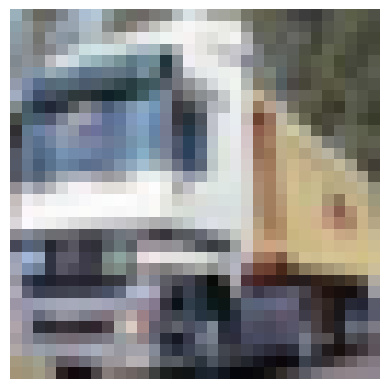

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("orig_1.ppm")
plt.imshow(img)
plt.axis("off")

### Analysis:
* Why did this optimization work (or not work as expected)?
* What did profiling reveal?
* What's the next bottleneck?

### Key Takeaways:
* Lessons learned from this optimization
* Applicability to other problems

## Phase 2.4: GPU Optimized Implementation - Version 2 (if applicable)


### Optimization Focus: (e.g., Kernel Fusion and Advanced Techniques)
Follow the same structure as Version 1:
* Objectives
* Implementation Details
* Results
* Analysis
* Key Takeaways

Note: You may have multiple optimization versions. Create a separate subsection for each major optimization iteration.

In [ ]:
.\gpu_main_ver2

## Phase 2.5: SVM Integration

### Objectives:
* Extract features using trained encoder
* Train SVM classifier on learned features
* Evaluate end-to-end classification performance

### Implementation Details:
* Feature Extraction: How you extracted 1,024-dim features from encoder
* LIBSVM Integration: How you interfaced with LIBSVM
* Hyperparameter Selection: SVM parameters chosen (C, gamma, kernel)
* Key Code Snippets: Feature extraction and SVM training code

### Results:
* Feature extraction time (50K train + 10K test)
* SVM training time
* Classification accuracy on test set
* Per-class accuracy breakdown (table)
* Confusion matrix (visualization)
* Comparison with baseline methods (if available)

In [ ]:
.\gpu_main_svm

### Analysis:
* Which classes are easiest/hardest to classify?
* What does the confusion matrix reveal?
* How does accuracy compare to expectations?

### Key Takeaways:
* Quality of learned features
* Effectiveness of two-stage approach

# Section 3: Comprehensive Performance Analysis

## 3.1 Performance Comparison Across All Phases

| Phase | Training Time | Speedup (vs CPU) | Incremental Speedup | Memory Usage | Key Optimization |
|-------|---------------|------------------|--------------------|--------------|------------------|
| CPU Baseline | 1800s | 1.0x | - | - | - |
| GPU Basic | 180s | 10.0x | 10.0x | 2.1 GB | Parallelization |
| GPU Opt v1 | 45s | 40.0x | 4.0x | 2.3 GB | Shared memory |
| GPU Opt v2 | 25s | 72.0x | 1.8x | 2.5 GB | Kernel Fusion + Streams |

### Visualization Requirements:
* Bar chart showing training time across phases
* Line graph showing cumulative speedup

# Section 4: Lessons Learned and Challenges Overcome

## 4.1 Key Technical Insights
What you have learn about: CUDA Programming, Deep Learning, Performance Optimization

## 4.2 Major Challenges and Solutions
Present 2-3 significant challenges using this format:
* Challenge 1: [Brief Title]
* Problem: One sentence describing the issue.
* Solution: 1-2 sentences explaining how you solved it.
* Lesson: One sentence on what you learned.

# Section 5: Conclusion and Future Work

## 5.1 Project Summary
* Recap of what was accomplished
* Final performance metrics summary table
* Achievement of original objectives

## 5.2 Key Achievements
Highlight your best results:
* Maximum speedup achieved
* Classification accuracy
* Most successful optimization
* Technical skills mastered

## 5.3 Limitations
Honestly discuss:
* Current performance bottlenecks
* Accuracy limitations
* Implementation constraints

## 5.4 Future Improvements